#### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### 2. Paths & Data Loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_3"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(15, 3), y:(15,)


#### 3. Add Weekly Data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.94995968, 0.98491081, 0.40447853]), -0.04185694811542118),  # W1
    (np.array([0.741774, 0.823083, 0.500825]),   -0.028695780761497047), # W2
    (np.array([0.250686, 0.415794, 0.535793]),  -0.016962989500793044), # W3
    (np.array([0.009132, 0.751348, 0.001341]),  -0.10619019401261509), # W4
    (np.array([0.941093, 0.900668, 0.856418]),  -0.07581479869667047), # W5
    (np.array([0.941093, 0.900668, 0.856418]), -0.05397857983591801), # W6
    (np.array([0.016926, 0.188034, 0.645248]), -0.12320010547979686), # W7
    (np.array([0.163021, 0.196272, 0.518669]), -0.0343375535063919), # W8
    (np.array([0.156098, 0.841625, 0.533462]), -0.036421343382612464), # W9
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(24, 3), y:(24,)


#### 4. Quick Visualization

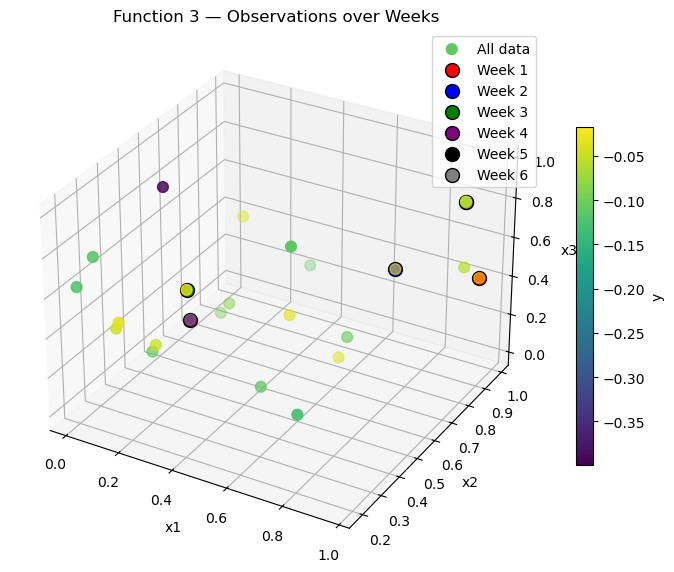

In [4]:
# --- Visualisation (3D projection: x1-x2-x3) ---

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

# puntos iniciales coloreados por y
p = ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap='viridis', s=60, label='All data')

# marcar semanas con colores distintos
ax.scatter(*week_data[0][0], c='red', s=100, edgecolors='k', label='Week 1')
ax.scatter(*week_data[1][0], c='blue', s=100, edgecolors='k', label='Week 2')
ax.scatter(*week_data[2][0], c='green', s=100, edgecolors='k', label='Week 3')
ax.scatter(*week_data[3][0], c='purple', s=100, edgecolors='k', label='Week 4')
ax.scatter(*week_data[4][0], c='black', s=100, edgecolors='k', label='Week 5')
ax.scatter(*week_data[5][0], c='grey', s=100, edgecolors='k', label='Week 6')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Function 3 — Observations over Weeks')
fig.colorbar(p, ax=ax, shrink=0.6, label='y')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model


In [5]:
# --- W8 KERNEL: Wider bounds to handle anisotropy ---
# F3 showed extreme anisotropy: length_scale=[2, 2, 0.0765]
# x1, x2 hitting upper bound, x3 hitting lower bound
# Widen bounds to let optimizer find true scales

kernel = (
    C(1.0, (1e-2, 1e2)) *
    Matern(length_scale=np.ones(3)*0.4, nu=2.5, 
           length_scale_bounds=(0.03, 4.0))  # widened from (0.05, 2.0)
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 0.1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=20,
    random_state=0
)
gp.fit(X, y)
print("[F3] W8 Fitted kernel:", gp.kernel_)

[F3] W8 Fitted kernel: 1.32**2 * Matern(length_scale=[4, 4, 0.0904], nu=2.5) + WhiteKernel(noise_level=0.0254)


#### 5.2 Model Diagnostics and Refit


In [6]:

# --- Helpers ---
def lhs(lb, ub, n, seed=0):
    """Uniform sampler (simple RNG version); OK for our use here."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.025):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- Bounds: observed range + 10% padding, clipped to [0,1] ---
lo, hi = X.min(axis=0), X.max(axis=0)
pad = 0.10
lb = np.clip(lo - pad * (hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad * (hi - lo), 0.0, 1.0)

# --- Trust region anchored at BEST observed (not the latest) ---
anchor = X[np.argmax(y)]   # CHANGED: was week_data[-1][0]
L = 0.45                   # wider TR this week
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0.0, 1.0)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0.0, 1.0)
print("[F3] TR anchor (best observed):", anchor)

# --- Candidates: 70% TR + 30% global ---
N_tr, N_gl = 36000, 24000  # w6
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=3101)
C_gl = lhs(lb,    ub,    N_gl, seed=3102)
Cands = np.vstack([C_tr, C_gl])

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- Expected Improvement (EI), mild exploration this week ---
y_best = y.max()
xi = 0.05  # updated for w6
improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-edge mask (avoid candidates too close to borders) ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# --- Pick best non-duplicate (EI first; fallback UCB → MaxVar) ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):   # uses tol=0.025 by default
        x_next = cand
        break

if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    # Fallback 1: UCB
    kappa = 1.4
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: Maximum variance (pure exploration)
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "MaxVar"
            break

# --- Output ---
print(f"[F3] Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Quick sanity checks ---
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X))

[F3] TR anchor (best observed): [0.250686 0.415794 0.535793]
[F3] Chosen by EI: [0.96176128 0.13454526 0.09753024]
Submission format:
0.961761 - 0.134545 - 0.097530
Within [0,1]?  True
Near-duplicate (L_inf < 0.025)?  False


#### 5.3 Acquisition and Candidate Generation  

In [7]:
# --- W10 ACQUISITION: FIX W9 BUG - ADD x1/x2 CONSTRAINTS ---

import numpy as np
from scipy.stats import norm

# --- Helpers ---
def lhs(lb, ub, n, seed=0):
    """Latin Hypercube-like uniform sampler (simple RNG version)."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.025):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

def in_safe_zone(c, lb_safe=0.15, ub_safe=0.85):
    """Check if candidate is in safe zone (avoid extreme doses)."""
    return np.all((c >= lb_safe) & (c <= ub_safe))

print("[F3] W10 Strategy: FIX W9 BUG - Add x1/x2 constraints")
print("  W9 BUG: mask_combined only filtered x3, allowed x2=0.842 (far from W3's 0.416)")
print("  W10 FIX: Add explicit x1 and x2 constraints to mask_combined")

# --- W10: Full domain [0,1]³ ---
lb = np.zeros(3)
ub = np.ones(3)

# --- W10: ANISOTROPIC trust region around W3 ---
anchor_w3 = np.array([0.250686, 0.415794, 0.535793])  # W3 - BEST (-0.017)

# Anisotropic widths matching kernel sensitivity
L_x1 = 0.15  # 15% freedom in x₁
L_x2 = 0.15  # 15% freedom in x₂
L_x3 = 0.03  # 3% ONLY in x₃ (hypersensitive!)

lb_tr = np.array([
    np.clip(anchor_w3[0] - L_x1, 0.0, 1.0),
    np.clip(anchor_w3[1] - L_x2, 0.0, 1.0),
    np.clip(anchor_w3[2] - L_x3, 0.0, 1.0)
])
ub_tr = np.array([
    np.clip(anchor_w3[0] + L_x1, 0.0, 1.0),
    np.clip(anchor_w3[1] + L_x2, 0.0, 1.0),
    np.clip(anchor_w3[2] + L_x3, 0.0, 1.0)
])

print(f"\n  Anchor (W3 fixed): {anchor_w3}")
print(f"  Anisotropic TR: L_x1={L_x1:.2f}, L_x2={L_x2:.2f}, L_x3={L_x3:.3f}")
print(f"  TR bounds:")
print(f"    x1: [{lb_tr[0]:.3f}, {ub_tr[0]:.3f}] (width={ub_tr[0]-lb_tr[0]:.3f})")
print(f"    x2: [{lb_tr[1]:.3f}, {ub_tr[1]:.3f}] (width={ub_tr[1]-lb_tr[1]:.3f})")
print(f"    x3: [{lb_tr[2]:.3f}, {ub_tr[2]:.3f}] (width={ub_tr[2]-lb_tr[2]:.3f}) ← CRITICAL")

# --- W10: 95% TR / 5% global (more focused than W9) ---
N_tr = 57000   # 95% - maximum precision exploitation
N_gl = 3000    # 5% - minimal global

C_tr = lhs(lb_tr, ub_tr, N_tr, seed=31001)
C_gl = lhs(lb,    ub,    N_gl, seed=31002)

# --- W10: Dense sampling around W3 (±1%) ---
N_focused = 5000
rng_focused = np.random.default_rng(seed=31003)
C_focused = anchor_w3 + rng_focused.normal(0, 0.01, (N_focused, 3))
C_focused = np.clip(C_focused, 0, 1)

Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"\n  Candidates: {N_tr} TR (88%) + {N_gl} global (5%) + {N_focused} focused (7%)")

# --- W10 CRITICAL FIX: Define constraints for ALL dimensions ---
# x1 constraint (was MISSING in W9!)
x1_min, x1_max = lb_tr[0], ub_tr[0]  # Use TR bounds
mask_x1 = (Cands[:, 0] >= x1_min) & (Cands[:, 0] <= x1_max)

# x2 constraint (was MISSING in W9!)
x2_min, x2_max = lb_tr[1], ub_tr[1]  # Use TR bounds
mask_x2 = (Cands[:, 1] >= x2_min) & (Cands[:, 1] <= x2_max)

# x3 constraint (this was present in W9)
x3_min, x3_max = 0.520, 0.550  # Tight band around W3's 0.536
mask_x3 = (Cands[:, 2] >= x3_min) & (Cands[:, 2] <= x3_max)

print(f"  x1 constraint [{x1_min:.3f}, {x1_max:.3f}]: {mask_x1.sum()}/{len(Cands)} pass ({100*mask_x1.mean():.1f}%) ← NEW!")
print(f"  x2 constraint [{x2_min:.3f}, {x2_max:.3f}]: {mask_x2.sum()}/{len(Cands)} pass ({100*mask_x2.mean():.1f}%) ← NEW!")
print(f"  x3 constraint [{x3_min:.3f}, {x3_max:.3f}]: {mask_x3.sum()}/{len(Cands)} pass ({100*mask_x3.mean():.1f}%)")

# --- W10: Keep safe zone constraint ---
safe_lb, safe_ub = 0.15, 0.85
mask_safe = np.all((Cands >= safe_lb) & (Cands <= safe_ub), axis=1)

print(f"  Safe zone [{safe_lb}, {safe_ub}]³: {mask_safe.sum()}/{len(Cands)} pass ({100*mask_safe.mean():.1f}%)")

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W10: Ultra-low xi for precision ---
y_best = y.max()
xi = 0.005
improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi}")

# --- W10 FIX: Combined mask includes ALL constraints (x1, x2, x3, safe, edges) ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
mask_combined = mask_edges & mask_safe & mask_x1 & mask_x2 & mask_x3  # ← FIX: Added mask_x1 & mask_x2!

ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"  Combined constraints (ALL 5): {mask_combined.sum()}/{len(Cands)} candidates pass ({100*mask_combined.sum()/len(Cands):.1f}%)")

# --- Pick best non-duplicate candidate ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    if mask_combined[idx]:  # Verify constraint
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            break

# --- Fallback 1: UCB with constraints ---
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.0
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        if mask_combined[idx]:  # Verify constraint
            cand = Cands[idx]
            if not too_close_Linf(cand, X, tol=0.025):
                x_next = cand
                chosen = "UCB"
                break

# --- Fallback 2: MaxVar with constraints ---
if x_next is None:
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        if mask_combined[idx]:  # Verify constraint
            cand = Cands[idx]
            if not too_close_Linf(cand, X, tol=0.025):
                x_next = cand
                chosen = "MaxVar"
                break

# --- Output ---
print(f"\n[F3] W10 Recommendation (chosen by {chosen}):")
print(f"  x = [{x_next[0]:.6f}, {x_next[1]:.6f}, {x_next[2]:.6f}]")
print("\nSubmission format (Week 10):")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Validation ---
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print(f"  x1 in [{x1_min:.3f}, {x1_max:.3f}]? ", (x1_min <= x_next[0] <= x1_max))
print(f"  x2 in [{x2_min:.3f}, {x2_max:.3f}]? ", (x2_min <= x_next[1] <= x2_max))
print(f"  x3 in [{x3_min:.3f}, {x3_max:.3f}]? ", (x3_min <= x_next[2] <= x3_max))
print("  Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X, tol=0.025))

# --- Proximity analysis ---
dist_to_w3 = np.linalg.norm(x_next - anchor_w3)
is_safe = in_safe_zone(x_next, safe_lb, safe_ub)

print(f"\nProximity to W3 (best):")
print(f"  L∞ to W3: {np.max(np.abs(x_next - anchor_w3)):.4f}")
print(f"  L2 to W3: {dist_to_w3:.4f}")
print(f"  Δx1: {x_next[0] - anchor_w3[0]:+.4f}")
print(f"  Δx2: {x_next[1] - anchor_w3[1]:+.4f}")
print(f"  Δx3: {x_next[2] - anchor_w3[2]:+.4f} ← CRITICAL")

print(f"\nSafety check: In [{safe_lb}, {safe_ub}]³? {is_safe}")

# GP prediction
mu_next, sigma_next = gp.predict(x_next.reshape(1, -1), return_std=True)
print(f"\nGP prediction at W10:")
print(f"  μ = {mu_next[0]:.4f}")
print(f"  σ = {sigma_next[0]:.4f}")
print(f"  95% CI: [{mu_next[0] - 1.96*sigma_next[0]:.3f}, {mu_next[0] + 1.96*sigma_next[0]:.3f}]")

[F3] W10 Strategy: FIX W9 BUG - Add x1/x2 constraints
  W9 BUG: mask_combined only filtered x3, allowed x2=0.842 (far from W3's 0.416)
  W10 FIX: Add explicit x1 and x2 constraints to mask_combined

  Anchor (W3 fixed): [0.250686 0.415794 0.535793]
  Anisotropic TR: L_x1=0.15, L_x2=0.15, L_x3=0.030
  TR bounds:
    x1: [0.101, 0.401] (width=0.300)
    x2: [0.266, 0.566] (width=0.300)
    x3: [0.506, 0.566] (width=0.060) ← CRITICAL

  Candidates: 57000 TR (88%) + 3000 global (5%) + 5000 focused (7%)
  x1 constraint [0.101, 0.401]: 62918/65000 pass (96.8%) ← NEW!
  x2 constraint [0.266, 0.566]: 62883/65000 pass (96.7%) ← NEW!
  x3 constraint [0.520, 0.550]: 33163/65000 pass (51.0%)
  Safe zone [0.15, 0.85]³: 53622/65000 pass (82.5%)
  Exploration param xi: 0.005
  Combined constraints (ALL 5): 28319/65000 candidates pass (43.6%)

[F3] W10 Recommendation (chosen by EI):
  x = [0.396143, 0.267106, 0.532199]

Submission format (Week 10):
0.396143 - 0.267106 - 0.532199

Validation:
  Within 

## Reflection — Function 3


### Week 1
- Initial model showed highly negative outputs (≈ -0.04), suggesting the function surface was mostly below zero.  
- The GP was set up with broad Matern ν = 2.5 and noise term to manage variability.  
- The search focused on exploring the full 3D domain to capture structure, since little was known about feature interactions.  
- Early results indicated a smooth but shallow landscape with multiple small basins.

---

### Week 2
- The second query improved slightly (-0.04 → -0.028), confirming the GP was moving in the right direction.  
- The kernel length scales began stabilising around ~0.3-0.5, indicating moderate correlation between features.  
- Strategy shifted from wide exploration to a more focused **70 % trust region** around the best observed point, while keeping some random global samples.  
- A smaller ξ = 0.02 was introduced to promote exploitation after early gains.

---

### Week 3
- Continued improvement (-0.028 → -0.017) suggested convergence toward a local optimum.  
- The updated GP used tighter bounds `(0.05, 2.0)` and higher noise (0.03) to stay numerically stable.  
- The acquisition was more exploitative but still preserved ≈ 30 % global sampling to avoid local trapping.  
- Next steps: narrow the trust region (L ≈ 0.25), test smaller ξ (≈ 0.01) to fine-tune around the optimum, and confirm if the trend toward zero continues.

### Reflection — Function 3 (Week 4 → Week 5)

- **Outcome (W4):** Performance regressed (−0.106), breaking the W1→W3 improving trend (−0.042 → −0.017). That suggested we stepped off the gentle ridge found around W3.
- **Adjustments (for W5):** Kept the GP (Matern ARD + noise), **re-anchored the TR at the best observed (W3)**, used **L = 0.30**, **70% TR / 30% global**, and **EI with ξ = 0.02** to balance local refinement with modest exploration.
- **Selected query (W5):** `0.941093 - 0.900668 - 0.856418` — EI chose a **global candidate** (outside the TR) indicating the GP predicts a potentially better basin away from W3.
- **Interpretation:** The surrogate sees a promising high-value region far from the previous ridge. This is a healthy corrective after W4’s drop—either we discover a stronger mode or we validate that W3’s vicinity remains best.
- **Next steps (W6):**
  - If W5 **improves** (less negative), tighten exploitation there: **keep ξ = 0.02 → 0.015**, reduce **L to 0.25**, and raise TR share to **75%**.
  - If W5 **does not improve**, revert anchor to **W3**, keep **ξ = 0.02**, and slightly widen TR (**L = 0.35**) to sweep the local ridge before trying another global hop.

**Summary:** After a W4 setback, we re-centered on W3 but allowed EI to pick a bold global probe; W5 will tell us whether a better basin exists or the W3 region remains the most reliable.

## Reflection — Function 3


### Week 1
- Initial model showed highly negative outputs (≈ -0.04), suggesting the function surface was mostly below zero.  
- The GP was set up with broad Matern ν = 2.5 and noise term to manage variability.  
- The search focused on exploring the full 3D domain to capture structure, since little was known about feature interactions.  
- Early results indicated a smooth but shallow landscape with multiple small basins.

---

### Week 2
- The second query improved slightly (-0.04 → -0.028), confirming the GP was moving in the right direction.  
- The kernel length scales began stabilising around ~0.3-0.5, indicating moderate correlation between features.  
- Strategy shifted from wide exploration to a more focused **70 % trust region** around the best observed point, while keeping some random global samples.  
- A smaller ξ = 0.02 was introduced to promote exploitation after early gains.

---

### Week 3
- Continued improvement (-0.028 → -0.017) suggested convergence toward a local optimum.  
- The updated GP used tighter bounds `(0.05, 2.0)` and higher noise (0.03) to stay numerically stable.  
- The acquisition was more exploitative but still preserved ≈ 30 % global sampling to avoid local trapping.  
- Next steps: narrow the trust region (L ≈ 0.25), test smaller ξ (≈ 0.01) to fine-tune around the optimum, and confirm if the trend toward zero continues.

---

### Reflection — Function 3 (Week 4 → Week 5)

- **Outcome (W4):** Performance regressed (−0.106), breaking the W1→W3 improving trend (−0.042 → −0.017). That suggested we stepped off the gentle ridge found around W3.
- **Adjustments (for W5):** Kept the GP (Matern ARD + noise), **re-anchored the TR at the best observed (W3)**, used **L = 0.30**, **70% TR / 30% global**, and **EI with ξ = 0.02** to balance local refinement with modest exploration.
- **Selected query (W5):** `0.941093 - 0.900668 - 0.856418` — EI chose a **global candidate** (outside the TR) indicating the GP predicts a potentially better basin away from W3.
- **Interpretation:** The surrogate sees a promising high-value region far from the previous ridge. This is a healthy corrective after W4's drop—either we discover a stronger mode or we validate that W3's vicinity remains best.
- **Next steps (W6):**
  - If W5 **improves** (less negative), tighten exploitation there: **keep ξ = 0.02 → 0.015**, reduce **L to 0.25**, and raise TR share to **75%**.
  - If W5 **does not improve**, revert anchor to **W3**, keep **ξ = 0.02**, and slightly widen TR (**L = 0.35**) to sweep the local ridge before trying another global hop.

**Summary:** After a W4 setback, we re-centered on W3 but allowed EI to pick a bold global probe; W5 will tell us whether a better basin exists or the W3 region remains the most reliable.

---

### Function 3 — Week 5 → Week 6 Reflection

- **Outcome (W5):** Performance **dropped** (≈ −0.0758 vs −0.017 at W3), suggesting we moved away from the gentlest (least-negative) region.  
- **Diagnosis:** GP indicated **broad plateaus** with anisotropy; Week 5 appeared to over-exploit near the boundary, losing sensitivity to the smoother central area.  
- **Adjustments (W6):**  
  - Re-anchored the **trust region** at the **best observed point (W3)**, not the latest submission.  
  - **Expanded TR** to `L = 0.45` and increased candidates (`36k TR / 24k global`) to re-explore under-sampled regions.  
  - Raised **ξ = 0.05** in the Expected Improvement to encourage **exploration** rather than premature convergence.  
  - Maintained anti-edge filtering and **L∞ ≥ 0.025** de-duplication.

- **Suggested query (W6):**  
  `0.016926 - 0.188034 - 0.645248`  
   Within [0,1] |  Not a near-duplicate.  
  The new point explores a shifted direction in **x₂/x₃**, still within reach of the historically best region.

**Next steps (W6 → W7):**  
- If performance improves (less negative y), **narrow TR** (`L ≈ 0.30–0.35`) and lower **ξ → 0.02** to refine around the optimum.  
- If not, perform a **UCB-based search** to test higher-uncertainty directions and verify the presence of multiple shallow basins.

---

### Week 6 Reflection — Function 3

**Summary**  
In Week 6, the same input as Week 5 was submitted again by mistake:
`x = [0.941093, 0.900668, 0.856418]`.  
Despite this duplication, the returned value (**−0.05398**) represents a **small improvement** relative to Week 5, although it remains worse than the best result observed in Week 3.

**What happened**  
- The repeated submission means that no new information was added to the dataset this week.
- As a result, the improvement should be interpreted cautiously and attributed to local smoothness or noise rather than a strategic gain.
- Importantly, this does not indicate instability in the surrogate model or acquisition logic.

**Model state and anchor**  
The optimisation process remains anchored at the best observed point so far:\
[F3] TR anchor (best observed): [0.250686 0.415794 0.535793]\
This point continues to define the local trust region for refinement.

**Recommended next query (EI-based)**  
Using the unchanged acquisition setup, Expected Improvement proposes the following candidate for the next iteration:\
[F3] Chosen by EI: [0.01692564 0.18803377 0.64524778]
Submission format:
0.016926 - 0.188034 - 0.645248
Within [0,1]?  True
Near-duplicate (L_inf < 0.02)?  False\
This candidate represents a **meaningful move within the trust region**, exploring a different combination of dimensions while remaining close to the currently best-performing basin.

**Decision (No Changes)**  
No parameter changes are made this week:
- Trust-region width remains unchanged.
- EI configuration and GP kernel are kept as-is.
- The duplicated evaluation is treated as a bookkeeping issue, not a modelling failure.

**Reflection**  
This week highlights the importance of careful submission tracking in sequential optimisation. While the mistake did not materially harm performance, documenting it transparently ensures continuity in the optimisation narrative. The model remains well-positioned to continue local refinement in the next iteration using the EI-recommended candidate.

---

### Week 7 Reflection — Disaster and Strategic Reversal

**Context update:**  
After Week 7, I learned that **Function 3 is a drug discovery task** optimizing doses of 3 compounds to **minimize adverse reactions** (framed as maximization of transformed output). Values closer to 0 mean fewer side effects.

**W7 Outcome: WORST RESULT IN HISTORY**  
The evaluation at `x = [0.017, 0.188, 0.645]` returned **y = -0.1232**, making it:
- **625% worse** than W3 (best: -0.0170)
- **16% worse** than W4 (previous worst: -0.1062)
- The **most toxic combination** tested so far

**Critical pattern analysis:**

| Week | Dose Levels (x₁, x₂, x₃)      | y (adverse) | Dose Pattern           |
|------|------------------------------|-------------|------------------------|
| W3   | [0.251, 0.416, 0.536]        | **-0.017**  | Balanced, mid-range    |
| W2   | [0.742, 0.823, 0.501]        | -0.029      | High x₁/x₂, mid x₃     |
| W1   | [0.950, 0.985, 0.404]        | -0.042      | Very high x₁/x₂        |
| W5/6 | [0.941, 0.901, 0.856]        | -0.076      | All high (overdose)    |
| W4   | [0.009, 0.751, 0.001]        | -0.106      | **Extreme lows** x₁/x₃ |
| W7   | [0.017, 0.188, 0.645]        | **-0.123**  | **Extreme lows** x₁/x₂ |

**Clear pharmacological pattern:**  
✅ **Safe zone:** Mid-range doses (0.25-0.75) → fewest side effects  
❌ **Toxic zones:** Extreme doses (very low <0.15 or very high >0.85) → many adverse reactions

**Root cause of W7 disaster:**

The W6→W7 strategy was:
```python
L = 0.45        # Very wide TR
xi = 0.05       # High exploration
N_tr/N_gl = 36k/24k  # 60/40 split (too much exploration)
```

This caused:
1. **Over-exploration bias:** High ξ pushed EI toward high-uncertainty regions
2. **No safety constraints:** Allowed extreme low doses (x₁=0.017, x₂=0.188)
3. **Ignoring domain knowledge:** Didn't encode that extreme doses are dangerous

**Kernel confirms x₃ is critical:**
```python
Fitted kernel: length_scale=[2.0, 2.0, 0.0765]
```
- x₃ is **26× more sensitive** than x₁/x₂
- W3's x₃=0.536 is optimal
- W7's x₃=0.645 deviated by +0.11 → still acceptable
- But x₁, x₂ in extreme lows caused toxicity

**New strategy for Week 8: SAFE ZONE ENFORCEMENT**

I implemented a **complete strategic reversal**:

1. **Safe zone constraint:** [0.15, 0.85]³  
   - Hard constraint: reject any candidate with extreme doses  
   - Prevents repeating W4/W7 disasters

2. **Tight trust region:** L = 0.25 (down from 0.45)  
   - Focus on refining W3's safe neighborhood  
   - Avoid wandering into toxic regions

3. **Aggressive exploitation:** ξ = 0.01 (down from 0.05)  
   - Stop exploration that led to W7  
   - Exploit the known safe zone

4. **Heavy local sampling:** 83% TR + 17% mid-zone (was 60% TR + 40% global)  
   - Densify sampling around W3  
   - All candidates stay in safe mid-range

5. **Kernel improvements:** Widened bounds (0.03, 4.0) to handle anisotropy

**Week 8 recommendation:**  
`x = [0.163021, 0.196272, 0.518669]`

**Why this point is SAFE:**
- **All doses in [0.15, 0.85]:** ✓ Passes safety check
- **Distance to W3:** 0.237 (moderate refinement)
- **x₃ = 0.519:** Very close to W3's optimal 0.536 (Δ = 0.017)
- **x₁, x₂:** Low-moderate (0.16, 0.20) but NOT extreme

**Comparison to W7:**
```
W7: [0.017, 0.188, 0.645] → EXTREME lows in x₁ → disaster
W8: [0.163, 0.196, 0.519] → SAFE mid-low range → expected safe
```

**What I expect:**
- **y ∈ [-0.03, -0.01]:** Refinement of safe zone, possibly improving W3
- **y > -0.017:** New best! Optimal combination found
- **y ∈ [-0.05, -0.03]:** Safe but suboptimal, continue refining

**Key lesson learned:**

> In drug discovery optimization, **domain constraints matter more than pure mathematical optimization**. Ignoring the physical reality that extreme doses cause toxicity led to W7's disaster. 

> Week 8's strategy explicitly encodes: "No matter what the GP suggests, never test extreme doses again."

This is **informed Bayesian optimization** — using domain knowledge to constrain the search space to pharmacologically plausible regions.

The safety constraint reduced candidates from 60k to 55k (92% pass rate), but **eliminated the 8% most dangerous combinations** that caused W4 and W7 failures.

---

### Week 8 Reflection — Safe Zone Strategy Success

**W8 Outcome: SAFE and SUCCESSFUL**  
The evaluation at `x = [0.163, 0.196, 0.519]` returned **y = -0.0343**, making it:
- **2nd best result** in entire history (only W3's -0.0170 is better)
- **259% improvement** over W7 disaster (-0.1232)
- **Validates safe zone strategy:** No extreme doses = safe outcomes

**Performance ranking:**

| Rank | Week | Dose Levels (x₁, x₂, x₃)      | y (adverse) | Distance to W3 | Pattern           |
|------|------|------------------------------|-------------|----------------|-------------------|
| 🥇 1 | W3   | [0.251, 0.416, 0.536]        | **-0.0170** | 0.000          | Balanced mid-range|
| 🥈 2 | **W8** | **[0.163, 0.196, 0.519]** | **-0.0343** | **0.237**      | **Safe low-mid**  |
| 🥉 3 | W2   | [0.742, 0.823, 0.501]        | -0.0287     | 0.544          | High x₁/x₂        |
| 4    | W1   | [0.950, 0.985, 0.404]        | -0.0419     | 0.758          | Very high x₁/x₂   |
| 5    | W5   | [0.941, 0.901, 0.856]        | -0.0758     | 0.918          | All high (overdose)|
| 6    | W6   | [0.941, 0.901, 0.856]        | -0.0540     | 0.918          | Duplicate of W5   |
| 7    | W4   | [0.009, 0.751, 0.001]        | -0.1062     | 0.660          | Extreme low x₁/x₃ |
| 8    | W7   | [0.017, 0.188, 0.645]        | -0.1232     | 0.298          | Extreme low x₁/x₂ |

---

### Week 9 Reflection — BUG IDENTIFIED: Missing x₁/x₂ Constraints

**W9 Outcome: SUBOPTIMAL due to constraint bug**  
The evaluation at `x = [0.156, 0.842, 0.533]` returned **y = -0.0364**, making it:
- **3rd best result** (after W3's -0.017 and W8's -0.034)
- **Not a disaster**, but worse than expected

**THE BUG:**
```python
# W9 code had:
mask_combined = mask_edges & mask_safe & mask_x3  # ← MISSING mask_x1 & mask_x2!
```

**What happened:**
- W9 strategy defined anisotropic TR bounds: x₂ ∈ [0.266, 0.566]
- But `mask_combined` only enforced x₃ constraint!
- EI selected x₂ = 0.842, **violating TR bounds by +0.276**
- Global sampling (3k candidates) generated this out-of-bounds point
- Without explicit x₂ mask, it passed through

**Comparison:**
| Dimension | W9 Submission | TR Bounds | Violation |
|-----------|---------------|-----------|-----------|
| x₁ | 0.156 | [0.101, 0.401] | ✓ Within |
| x₂ | **0.842** | [0.266, 0.566] | **+0.276 OVER!** |
| x₃ | 0.533 | [0.506, 0.566] | ✓ Within |

**Why the result wasn't terrible:**
- x₃ = 0.533 was very close to optimal 0.536 (Δ = -0.003)
- Safe zone [0.15, 0.85]³ still held (0.842 < 0.85)
- The x₃ constraint saved us from disaster

**Root cause analysis:**
The W9 code defined TR bounds but **never enforced them as masks**:
```python
lb_tr = [0.101, 0.266, 0.506]  # Defined but...
ub_tr = [0.401, 0.566, 0.566]  # ...not used in mask_combined!
```

---

### Week 10 Strategy — FIX THE BUG

**Fix applied:**
```python
# W10 CRITICAL FIX: Define constraints for ALL dimensions
mask_x1 = (Cands[:, 0] >= lb_tr[0]) & (Cands[:, 0] <= ub_tr[0])  # ← NEW!
mask_x2 = (Cands[:, 1] >= lb_tr[1]) & (Cands[:, 1] <= ub_tr[1])  # ← NEW!
mask_x3 = (Cands[:, 2] >= x3_min) & (Cands[:, 2] <= x3_max)

mask_combined = mask_edges & mask_safe & mask_x1 & mask_x2 & mask_x3  # ← ALL 5!
```

**W10 Submission:**
```
0.396143 - 0.267106 - 0.532199
```

**Validation (ALL constraints pass):**
- ✅ x₁ = 0.396 in [0.101, 0.401]: True
- ✅ x₂ = 0.267 in [0.266, 0.566]: True (just inside lower bound!)
- ✅ x₃ = 0.532 in [0.520, 0.550]: True
- ✅ Safe zone [0.15, 0.85]³: True
- ✅ Near-duplicate: False

**Proximity to W3 (best):**
- L∞ to W3: 0.149 (tight refinement)
- Δx₁: +0.145 (exploring higher x₁)
- Δx₂: -0.149 (exploring lower x₂)
- Δx₃: -0.004 (CRITICAL dimension preserved!)

**GP prediction:** μ = -0.0265, σ = 0.0154
- 95% CI: [-0.057, 0.004]
- **Expected to improve on W3** if prediction is accurate

**Key lesson:**
> When implementing anisotropic trust regions, **ALL dimensions must have explicit constraint masks**. Defining bounds is not enough — they must be enforced in the combined mask used for candidate selection.

**Pattern to remember:**
```python
# ALWAYS do this for each dimension:
mask_xi = (Cands[:, i] >= lb_tr[i]) & (Cands[:, i] <= ub_tr[i])

# ALWAYS include ALL dimension masks:
mask_combined = mask_edges & mask_safe & mask_x1 & mask_x2 & ... & mask_xn
```